In [2]:
import math
import pandas as pd
import numpy as np
from dateutil.parser import parse
import datetime
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_white, het_breuschpagan

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import normalize
from sklearn.linear_model import Lasso

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

/Users/will/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/Users/will/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Reading data and cleaning files

In [3]:
# read in my movie data nad lets take a look!
# 502 movies taken between 2010 and 2017
movies_df = pd.read_csv('movies729.csv')
movies_df.head()

title release_date   mpaa  runtime  rating  \
0  Star Wars: The Force Awakens    18-Dec-15  PG-13      136     8.1   
1            The Wedding Ringer    16-Jan-15      R      101     6.7   
2                     The Visit    11-Sep-15  PG-13       94     6.2   
3                Magic Mike XXL     1-Jul-15      R      115     5.7   
4                      War Room    28-Aug-15     PG      120     6.4   

                            genres  number_reviews  production_budget  \
0  Action,Adventure,Fantasy,Sci-Fi          670255          245000000   
1                           Comedy           59500           23000000   
2                  Horror,Thriller           83345            5000000   
3               Comedy,Drama,Music           42965           14800000   
4                            Drama           10010            3000000   

   opening_weekend        gross  fb_likes  
0      247966675.0  936627416.0    267000  
1       24500000.0   64460211.0     74000  
2       25427560.0   65069140.0     29000  
3       11600000.0   66009973.0     41000  
4       11351389.0   67790117.0     30000

In [3]:
# lets change release_date into a datetime object
movies_df['release_date'] = [parse(datestring) for datestring in movies_df.release_date]
movies_df.head()

title release_date   mpaa  runtime  rating  \
0  Star Wars: The Force Awakens   2015-12-18  PG-13      136     8.1   
1            The Wedding Ringer   2015-01-16      R      101     6.7   
2                     The Visit   2015-09-11  PG-13       94     6.2   
3                Magic Mike XXL   2015-07-01      R      115     5.7   
4                      War Room   2015-08-28     PG      120     6.4   

                            genres  number_reviews  production_budget  \
0  Action,Adventure,Fantasy,Sci-Fi          670255          245000000   
1                           Comedy           59500           23000000   
2                  Horror,Thriller           83345            5000000   
3               Comedy,Drama,Music           42965           14800000   
4                            Drama           10010            3000000   

   opening_weekend        gross  fb_likes  
0      247966675.0  936627416.0    267000  
1       24500000.0   64460211.0     74000  
2       25427560.0   65069140.0     29000  
3       11600000.0   66009973.0     41000  
4       11351389.0   67790117.0     30000

In [5]:
# adjust for inflation to 2007 dollars
# this takes a while ...

base = 207.3 # 2007 
cpi = [215.303, 214.537, 218.056, 224.939, 229.594, 232.957, 236.736, 237.017, 240.007,243.801]

for index, row in movies_df.iterrows():
    if row.release_date.year == 2008:
        movies_df.gross[index] *= base/cpi[0] 
        movies_df.production_budget[index] *= base/cpi[0]
        movies_df.opening_weekend[index] *= base/cpi[0]
    elif row.release_date.year == 2009:
        movies_df.gross[index] *= base/cpi[1] 
        movies_df.production_budget[index] *= base/cpi[1]
        movies_df.opening_weekend[index] *= base/cpi[1]
    elif row.release_date.year == 2010:
        movies_df.gross[index] *= base/cpi[2] 
        movies_df.production_budget[index] *= base/cpi[2]
        movies_df.opening_weekend[index] *= base/cpi[2]
    elif row.release_date.year == 2011:
        movies_df.gross[index] *= base/cpi[3] 
        movies_df.production_budget[index] *= base/cpi[3]
        movies_df.opening_weekend[index] *= base/cpi[3]
    elif row.release_date.year == 2012:
        movies_df.gross[index] *= base/cpi[4] 
        movies_df.production_budget[index] *= base/cpi[4]
        movies_df.opening_weekend[index] *= base/cpi[4]
    elif row.release_date.year == 2013:
        movies_df.gross[index] *= base/cpi[5] 
        movies_df.production_budget[index] *= base/cpi[5]
        movies_df.opening_weekend[index] *= base/cpi[5]
    elif row.release_date.year == 2014:
        movies_df.gross[index] *= base/cpi[6] 
        movies_df.production_budget[index] *= base/cpi[6]
        movies_df.opening_weekend[index] *= base/cpi[6]
    elif row.release_date.year == 2015:
        movies_df.gross[index] *= base/cpi[7] 
        movies_df.production_budget[index] *= base/cpi[7]
        movies_df.opening_weekend[index] *= base/cpi[7]
    elif row.release_date.year == 2016:
        movies_df.gross[index] *= base/cpi[8] 
        movies_df.production_budget[index] *= base/cpi[8]
        movies_df.opening_weekend[index] *= base/cpi[8]
    elif row.release_date.year == 2017:
        movies_df.gross[index] *= base/cpi[9] 
        movies_df.production_budget[index] *= base/cpi[9]
        movies_df.opening_weekend[index] *= base/cpi[9]

In [6]:
movies_df.head()

title release_date   mpaa  runtime  rating  \
0  Star Wars: The Force Awakens   2015-12-18  PG-13      136     8.1   
1            The Wedding Ringer   2015-01-16      R      101     6.7   
2                     The Visit   2015-09-11  PG-13       94     6.2   
3                Magic Mike XXL   2015-07-01      R      115     5.7   
4                      War Room   2015-08-28     PG      120     6.4   

                            genres  number_reviews  production_budget  \
0  Action,Adventure,Fantasy,Sci-Fi          670255          214282097   
1                           Comedy           59500           20116278   
2                  Horror,Thriller           83345            4373104   
3               Comedy,Drama,Music           42965           12944387   
4                            Drama           10010            2623862   

   opening_weekend         gross  fb_likes  
0     2.168768e+08  8.191938e+08    267000  
1     2.142821e+07  5.637824e+07     74000  
2     2.223947e+07  5.691082e+07     29000  
3     1.014560e+07  5.773370e+07     41000  
4     9.928161e+06  5.929065e+07     30000

In [7]:
# Not Rated = Unrated in the mpaa column, also for nan, lets make them all 'Unrated'
movies_df.mpaa[(movies_df.mpaa == 'Not Rated')] = 'Unrated'
movies_df.mpaa.unique()


array(['PG-13', 'R', 'PG', 'G', 'Unrated', 'NC-17'], dtype=object)

In [8]:
# unique genres
allGenreList = [genreList.split() for genreList in movies_df.genres]
uniqueList = []

for lst in allGenreList:
    for genre in lst:
        uniqueList.extend(genre.split(','))
set(uniqueList)

{'Action',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Drama',
 'Family',
 'Fantasy',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Sport',
 'Thriller',
 'War',
 'Western'}

### creating some dummy variables

In [9]:
# lets create a holiday seasons dummy
holiday_season = [(12,i) for i in range(17,26)] + \
                 [(11,i) for i in range(18,28)] + \
                 [(5,i) for i in range(28, 32)] + \
                 [(5,i) for i in range(8, 14)] + \
                 [(9,i) for i in range(1,6)] + \
                 [(10,i) for i in range(29,32)] + \
                 [(2,i) for i in range(12,15)] + \
                 [(7,4)]

is_holiday_season = []                    
for index, row in movies_df.iterrows():
    if (row.release_date.month, row.release_date.day) in holiday_season:
        is_holiday_season.append(1)
    else:
        is_holiday_season.append(0)

movies_df['is_holiday_season'] = is_holiday_season           
# movies_df[movies_df['is_holiday_season'] == 1]

In [10]:
# lets create a is_horror dummy

is_horror = []                    
for index, row in movies_df.iterrows():
    if 'Horror' in row.genres.split(','):
        is_horror.append(1)
    else:
        is_horror.append(0)

movies_df['is_horror'] = is_horror


In [11]:
# lets create a is_scifi_adventure dummy

is_scifi_adventure = []                    
for index, row in movies_df.iterrows():
    if 'Sci-Fi' in row.genres.split(',') and \
       'Adventure' in row.genres.split(','):
        
        is_scifi_adventure.append(1)
    else:
        is_scifi_adventure.append(0)

movies_df['is_scifi_adventure'] = is_scifi_adventure


In [12]:
# lets create a is_war dummy

is_war = []                    
for index, row in movies_df.iterrows():
    if 'War' in row.genres.split(','):
        
        is_war.append(1)
    else:
        is_war.append(0)

movies_df['is_war'] = is_war


##### creating different functional mapping from regressors to response variable in the event that I need them

In [13]:
# lets create a log_gross
movies_df['log_gross'] = np.log(movies_df['gross'])

In [14]:
# lets create a log_production_budget
movies_df['log_production_budget'] = np.log(movies_df['production_budget'])

In [15]:
# lets create a log_opening_weekend
movies_df['log_opening_weekend'] = np.log(movies_df['opening_weekend'])

In [16]:
# lets create a log_fb_likes
movies_df['log_fb_likes'] = np.log(movies_df['fb_likes'])

In [17]:
# lets create a production_budget squared
movies_df['production_budget_sq'] = movies_df['production_budget']**2

In [18]:
# lets create a production_budget squared
movies_df['fb_likes_sq'] = np.log(movies_df['fb_likes'])

In [19]:
# there could perhaps be interacting effects between opening_weekend_gross and is_holiday_season releases
# lets account for potential interaction effects

movies_df['inter_holiday_logOpeningGross'] = movies_df.is_holiday_season * movies_df.log_opening_weekend

In [20]:
# there could potentially be interacting effect between fb_likes and score ratings 
# lets account for potential interaction effects

movies_df['inter_fb_rating'] = movies_df.fb_likes * movies_df.rating

In [21]:
movies_df['log_rating'] = np.log(movies_df.rating)

In [22]:
# there could potentially be interacting effect between fb_likes and score ratings 
# lets account for potential interaction effects

movies_df['inter_logfFBLikes_logOpening'] = movies_df.log_fb_likes * movies_df.log_opening_weekend

In [23]:
# there could potentially be interacting effect between imdb score ratings and opening weekend
# lets account for potential interaction effects

movies_df['inter_logRating_logOpening'] = movies_df.log_rating * movies_df.log_opening_weekend

In [24]:
# there could potentially be interacting effect between production budget and opening weekend gross
# lets account for potential interaction effects

movies_df['inter_logProdBudget_logOpening'] = movies_df.log_production_budget * movies_df.log_opening_weekend

In [25]:
# there could potentially be interacting effect between fb_likes and score ratings 
# lets account for potential interaction effects

movies_df['inter_logfFBLikes_logRating'] = movies_df.log_fb_likes * movies_df.log_rating

In [26]:
# there could potentially be interacting effect between production_budget and score ratings 
# lets account for potential interaction effects

movies_df['inter_logfprodBudget_logRating'] = movies_df.log_production_budget * movies_df.log_rating

In [27]:
# movies_df = movies_df.drop(['inter_log_prodBudget_logOpening','inter_log_rating_logOpening'], axis = 1)
movies_df.head()

title release_date   mpaa  runtime  rating  \
0  Star Wars: The Force Awakens   2015-12-18  PG-13      136     8.1   
1            The Wedding Ringer   2015-01-16      R      101     6.7   
2                     The Visit   2015-09-11  PG-13       94     6.2   
3                Magic Mike XXL   2015-07-01      R      115     5.7   
4                      War Room   2015-08-28     PG      120     6.4   

                            genres  number_reviews  production_budget  \
0  Action,Adventure,Fantasy,Sci-Fi          670255          214282097   
1                           Comedy           59500           20116278   
2                  Horror,Thriller           83345            4373104   
3               Comedy,Drama,Music           42965           12944387   
4                            Drama           10010            2623862   

   opening_weekend         gross               ...                \
0     2.168768e+08  8.191938e+08               ...                 
1     2.142821e+07  5.637824e+07               ...                 
2     2.223947e+07  5.691082e+07               ...                 
3     1.014560e+07  5.773370e+07               ...                 
4     9.928161e+06  5.929065e+07               ...                 

   production_budget_sq  fb_likes_sq  inter_holiday_logOpeningGross  \
0     45916817094717409    12.495004                       19.19484   
1       404664640573284    11.211820                        0.00000   
2        19124038594816    10.275051                        0.00000   
3       167557154805769    10.621327                        0.00000   
4         6884651795044    10.308953                        0.00000   

   inter_fb_rating  log_rating  inter_logfFBLikes_logOpening  \
0        2162700.0    2.091864                    239.839602   
1         495800.0    1.902108                    189.257981   
2         179800.0    1.824549                    173.826937   
3         233700.0    1.740466                    171.349103   
4         192000.0    1.856298                    166.086359   

   inter_logRating_logOpening  inter_logProdBudget_logOpening  \
0                   40.152996                      368.210853   
1                   32.107991                      283.875313   
2                   30.866592                      258.683370   
3                   28.078159                      264.189440   
4                   29.906605                      238.121435   

   inter_logfFBLikes_logRating  inter_logfprodBudget_logRating  
0                    26.137850                       40.127818  
1                    21.326088                       31.987818  
2                    18.747337                       27.899153  
3                    18.486061                       28.502175  
4                    19.136488                       27.436377  

[5 rows x 29 columns]

### Lets take a look at the distribution of my response variable and regressors

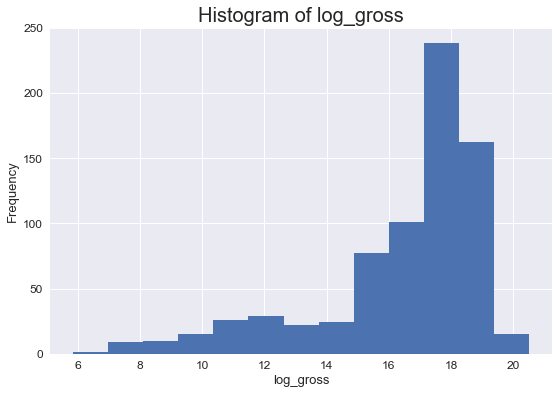

In [31]:
fig, logGross_hist = plt.subplots(figsize = (9,6))
plt.hist(movies_df.log_gross,bins = 13)

logGross_hist.set_title('Histogram of log_gross', fontsize = 20)
logGross_hist.set_xlabel('log_gross', fontsize = 13)
logGross_hist.set_ylabel('Frequency', fontsize = 13)
logGross_hist.tick_params(labelsize = 12)

# negatively skewed

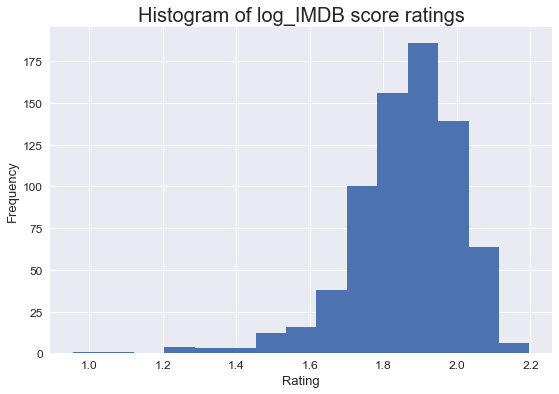

In [32]:
fig, rating_hist = plt.subplots(figsize = (9,6))
plt.hist(movies_df.log_rating,bins = 15)

rating_hist.set_title('Histogram of log_IMDB score ratings', fontsize = 20)
rating_hist.set_xlabel('Rating', fontsize = 13)
rating_hist.set_ylabel('Frequency', fontsize = 13)
rating_hist.tick_params(labelsize = 12)

# slightly negatively skewed

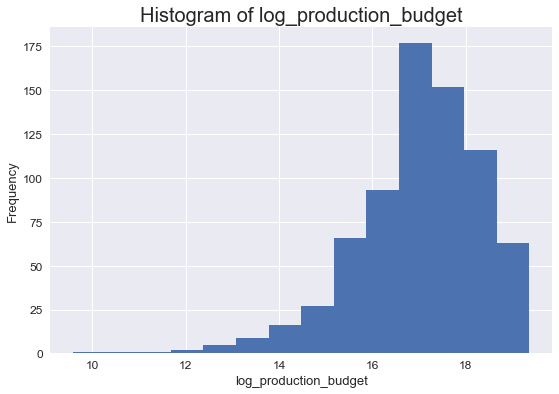

In [33]:
fig, logProdBudget_hist = plt.subplots(figsize = (9,6))
plt.hist(movies_df.log_production_budget,bins = 14)

logProdBudget_hist.set_title('Histogram of log_production_budget', fontsize = 20)
logProdBudget_hist.set_xlabel('log_production_budget', fontsize = 13)
logProdBudget_hist.set_ylabel('Frequency', fontsize = 13)
logProdBudget_hist.tick_params(labelsize = 12)

# slightly negatively skewed

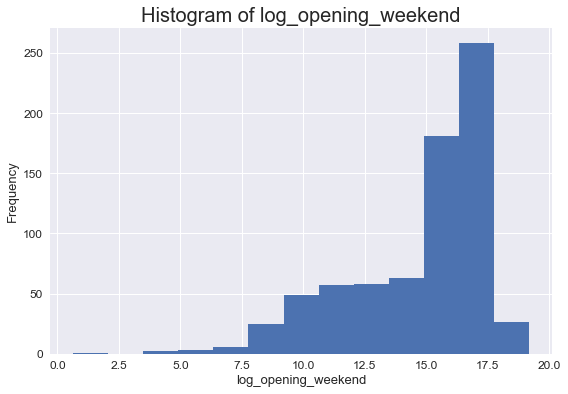

In [34]:
fig, logOpening_hist = plt.subplots(figsize = (9,6))
plt.hist(movies_df.log_opening_weekend,bins = 13)

logOpening_hist.set_title('Histogram of log_opening_weekend', fontsize = 20)
logOpening_hist.set_xlabel('log_opening_weekend', fontsize = 13)
logOpening_hist.set_ylabel('Frequency', fontsize = 13)
logOpening_hist.tick_params(labelsize = 12)

# negatively skewed

### Standardizing some of my variables

In [35]:
movies_df_norm = deepcopy(movies_df)

# for i,r in movies_df.iterrows():
#     if ('Drama' not in r.genres) and ('Romance' not in r.genres):
#         movies_df_norm = movies_df_norm.drop([i],axis = 0)

# for i,r in movies_df.iterrows():
#     if (r.release_date.month != 7) and (r.release_date.month != 6) and (r.release_date.month != 5) and (r.release_date.month != 8):
#         movies_df_norm = movies_df_norm.drop([i],axis = 0)
        
# for i,r in movies_df.iterrows():
#     if (r.is_holiday_season == 1) or (r.release_date.month == 7) or (r.release_date.month == 6) or (r.release_date.month == 5) or (r.release_date.month == 12) or (r.release_date.month == 1):
#         movies_df_norm = movies_df_norm.drop([i],axis = 0)

for column in movies_df.columns:
    if column in ['number_reviews', 'opening_weekend', 'production_budget',
                  'fb_likes', 'inter_holiday_openingGross', 'rating',
                  'inter_fb_rating', 'gross']:
        mean = np.mean(movies_df[column])
        std = np.std(movies_df[column])
        
        movies_df_norm[column] = (movies_df[column] - mean)/std

In [36]:
movies_df_norm.shape

(729, 29)

In [37]:
movies_df_norm.head()

title release_date   mpaa  runtime    rating  \
0  Star Wars: The Force Awakens   2015-12-18  PG-13      136  1.775669   
1            The Wedding Ringer   2015-01-16      R      101  0.220625   
2                     The Visit   2015-09-11  PG-13       94 -0.334747   
3                Magic Mike XXL   2015-07-01      R      115 -0.890120   
4                      War Room   2015-08-28     PG      120 -0.112598   

                            genres  number_reviews  production_budget  \
0  Action,Adventure,Fantasy,Sci-Fi        3.393110           3.520724   
1                           Comedy       -0.443897          -0.535566   
2                  Horror,Thriller       -0.294093          -0.864455   
3               Comedy,Drama,Music       -0.547776          -0.685393   
4                            Drama       -0.754813          -0.900998   

   opening_weekend     gross               ...                \
0         8.938291  9.833562               ...                 
1         0.284053 -0.032320               ...                 
2         0.319974 -0.025432               ...                 
3        -0.215528 -0.014789               ...                 
4        -0.225156  0.005348               ...                 

   production_budget_sq  fb_likes_sq  inter_holiday_logOpeningGross  \
0     45916817094717409    12.495004                       19.19484   
1       404664640573284    11.211820                        0.00000   
2        19124038594816    10.275051                        0.00000   
3       167557154805769    10.621327                        0.00000   
4         6884651795044    10.308953                        0.00000   

   inter_fb_rating  log_rating  inter_logfFBLikes_logOpening  \
0         8.078605    2.091864                    239.839602   
1         1.050234    1.902108                    189.257981   
2        -0.282158    1.824549                    173.826937   
3        -0.054893    1.740466                    171.349103   
4        -0.230718    1.856298                    166.086359   

   inter_logRating_logOpening  inter_logProdBudget_logOpening  \
0                   40.152996                      368.210853   
1                   32.107991                      283.875313   
2                   30.866592                      258.683370   
3                   28.078159                      264.189440   
4                   29.906605                      238.121435   

   inter_logfFBLikes_logRating  inter_logfprodBudget_logRating  
0                    26.137850                       40.127818  
1                    21.326088                       31.987818  
2                    18.747337                       27.899153  
3                    18.486061                       28.502175  
4                    19.136488                       27.436377  

[5 rows x 29 columns]

### A pairplot and a heatmap to let me see how variables relate to one another

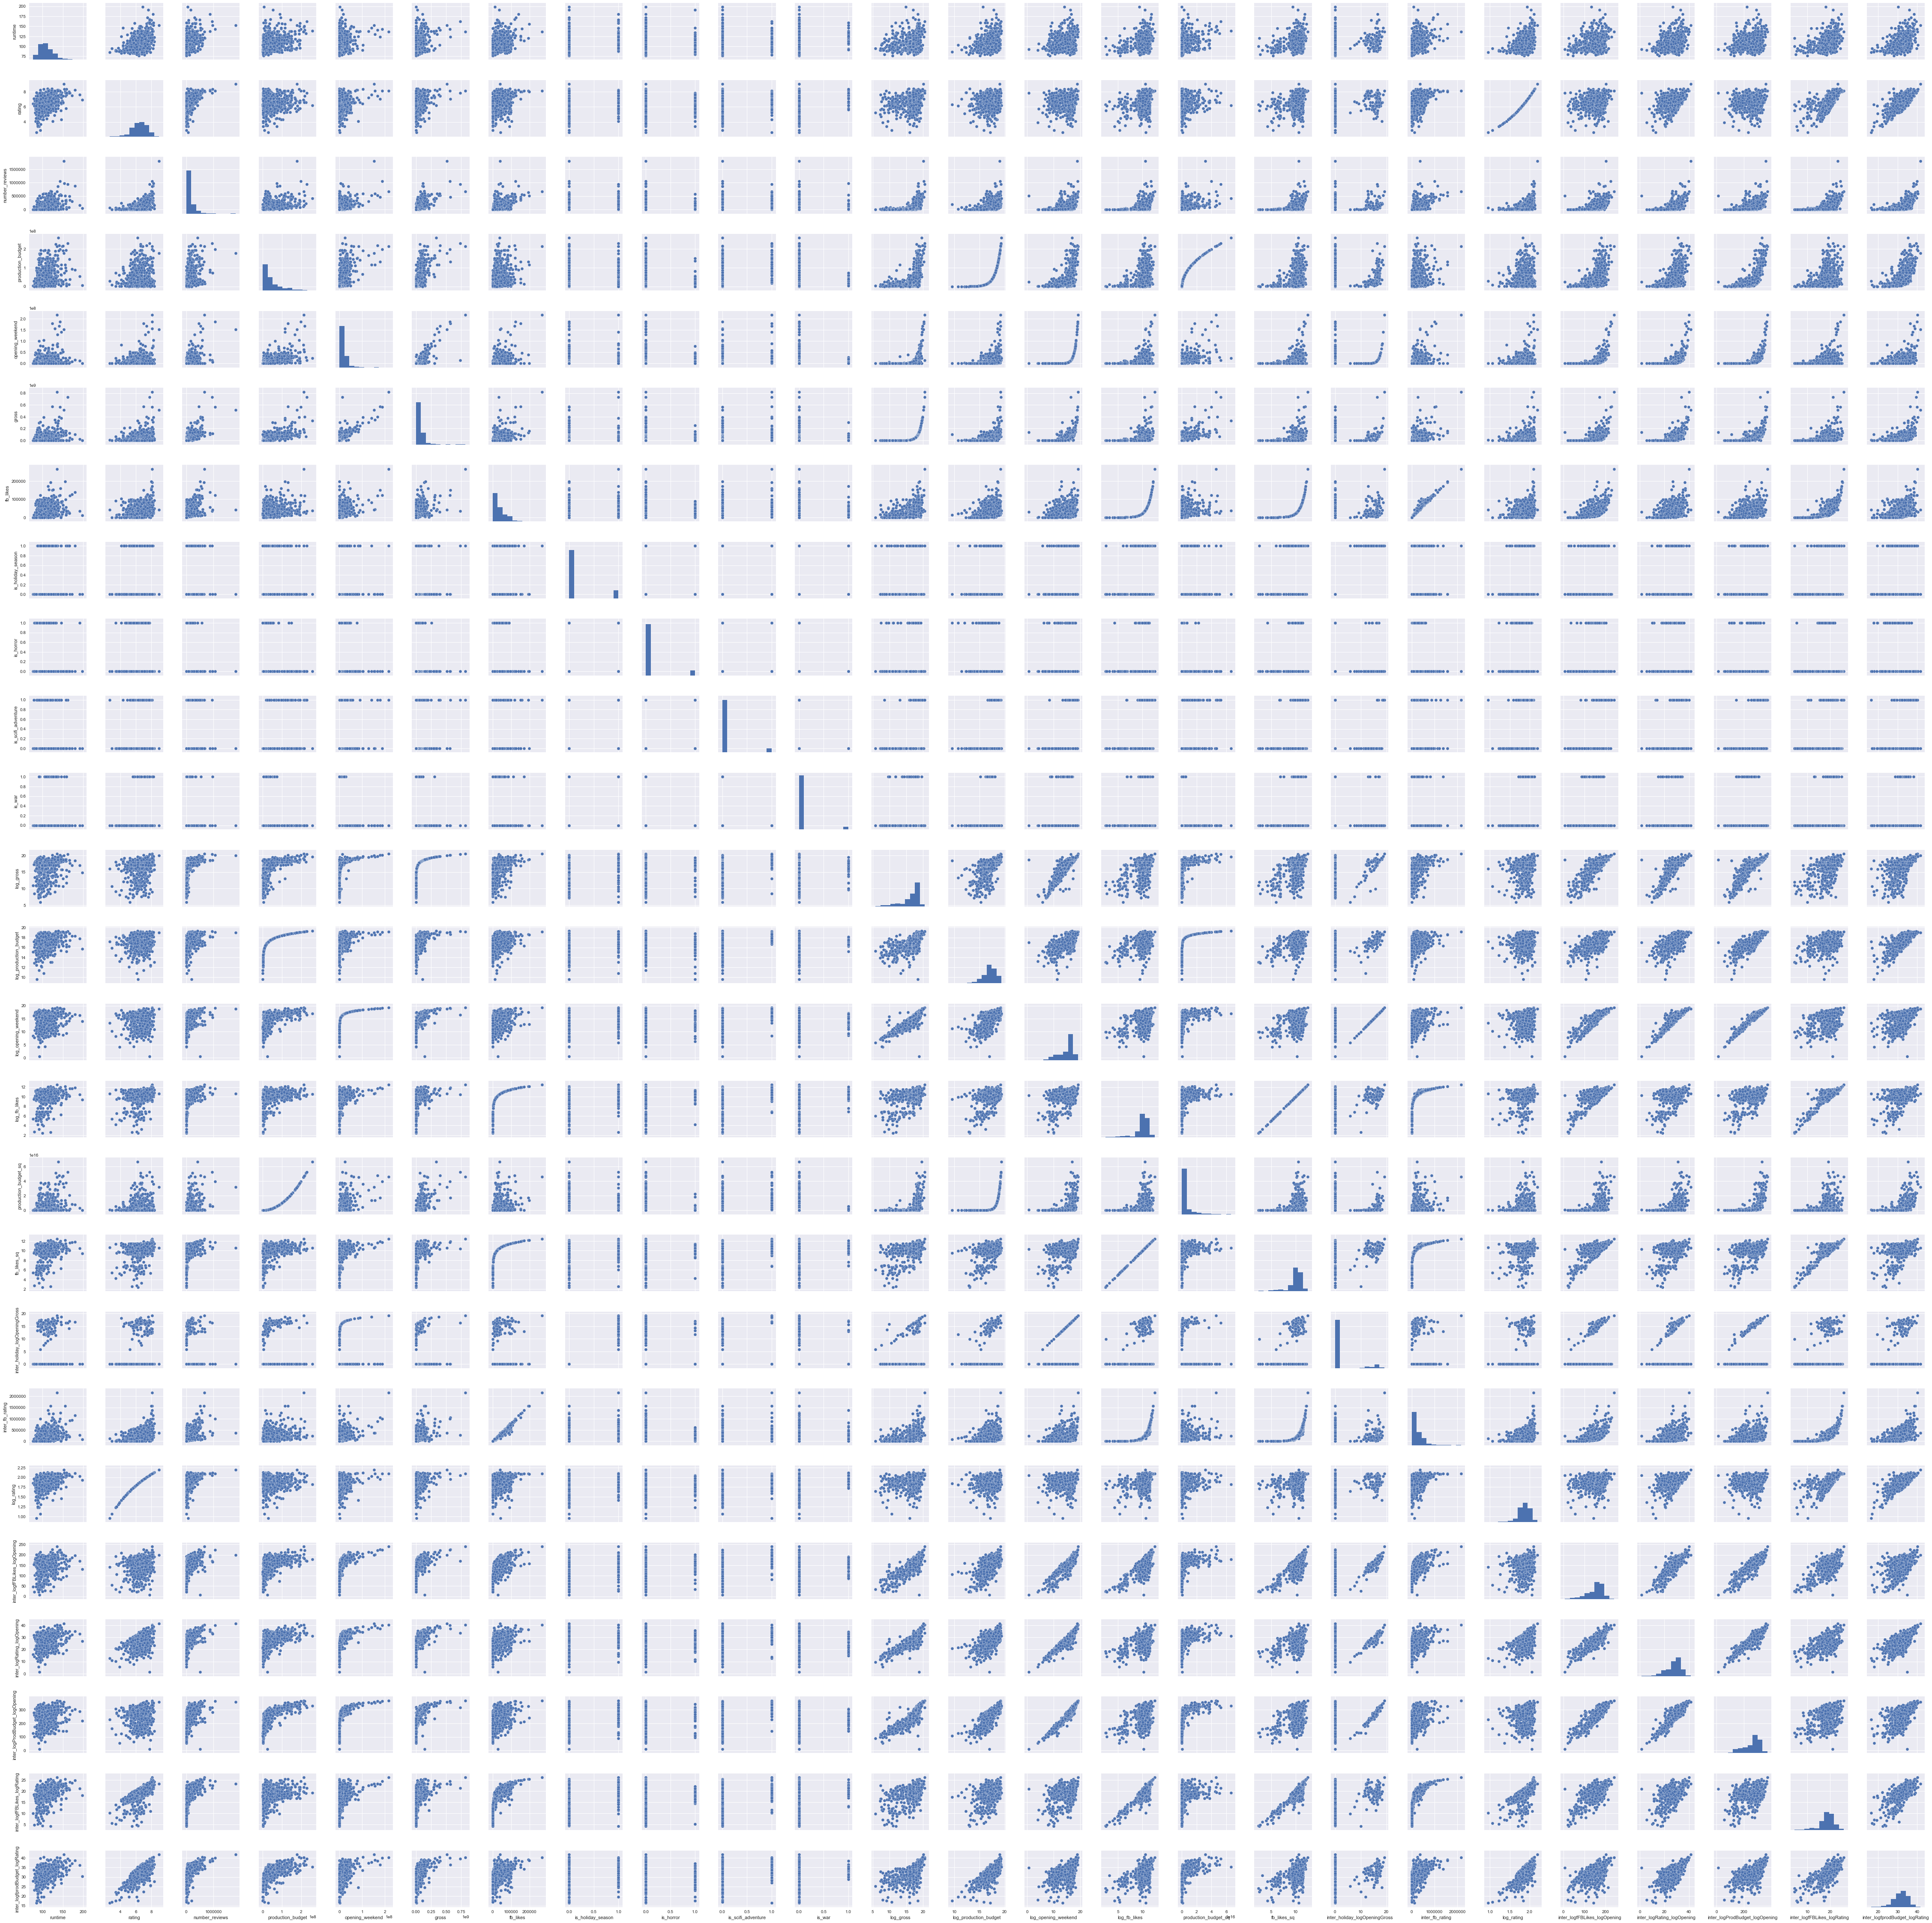

In [38]:
sns.pairplot(movies_df)

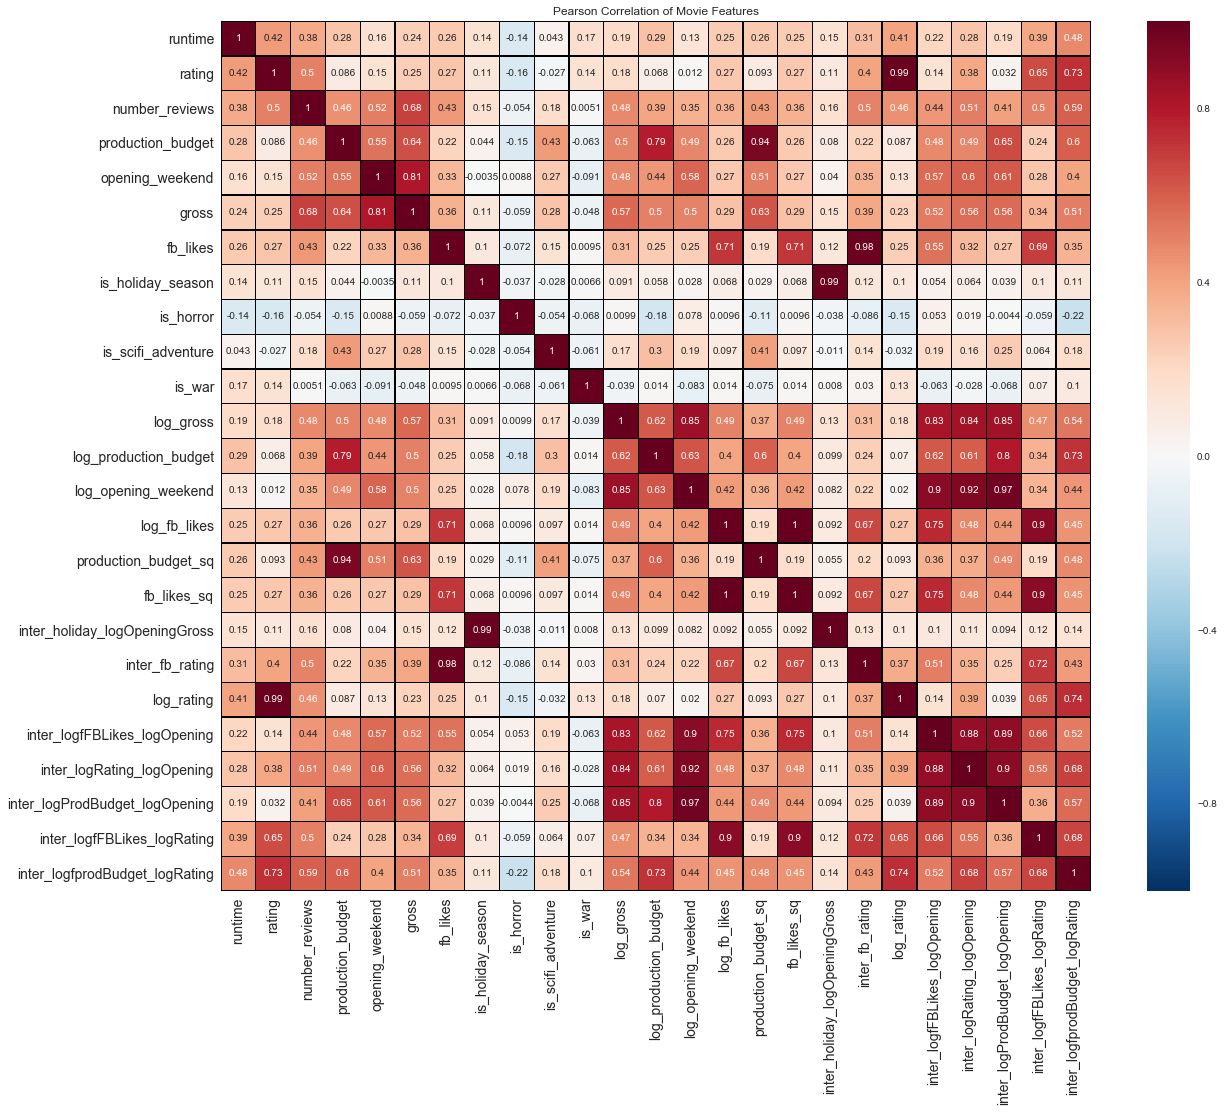

In [95]:
f, ax = plt.subplots(figsize=(20, 16))
plt.title('Pearson Correlation of Movie Features')
# Draw the heatmap using seaborn
sns.heatmap(movies_df.corr(method = 'pearson'),linewidths=0.25,vmax=1.0, square=True, linecolor='black', annot=True)

ax.tick_params(labelsize = 14)

In [40]:
# after testing multiple times, I ended up dropping alot of genres dummys as they arent predictive

y = movies_df_norm.log_gross
X = movies_df_norm.drop(['log_gross', 'gross','title','release_date','genres',
                         'mpaa','production_budget_sq','runtime','is_horror','is_war',
                         'opening_weekend','inter_fb_rating','production_budget','is_scifi_adventure',
                         'fb_likes','fb_likes_sq','is_holiday_season', 'inter_holiday_logOpeningGross',
                         'number_reviews','rating','inter_logRating_logOpening', 'inter_logProdBudget_logOpening',
                         'inter_logfFBLikes_logRating','inter_logfprodBudget_logRating' ], axis = 1)

In [41]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 5 columns):
log_production_budget           729 non-null float64
log_opening_weekend             729 non-null float64
log_fb_likes                    729 non-null float64
log_rating                      729 non-null float64
inter_logfFBLikes_logOpening    729 non-null float64
dtypes: float64(5)
memory usage: 28.6 KB


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Training the model through statsmodel

In [68]:
trainingSet = pd.concat([y_train, X_train], axis = 1)

[('Lagrange multiplier statistic', 308.59590145326922),
 ('p-value', 3.4525291206371744e-54),
 ('f-value', 35.986042177400954),
 ('f p-value', 2.163751089044339e-82)]

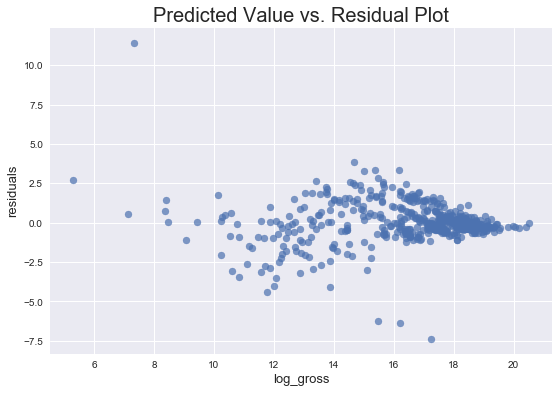

In [69]:
# lets check the residuals plots

check_results = (smf.ols('log_gross ~ log_production_budget + log_opening_weekend + log_rating + \
                          log_fb_likes + inter_logfFBLikes_logOpening',
                         data=trainingSet).fit())

fig, resid_plot = plt.subplots(figsize = (9,6))
plt.scatter(check_results.predict(), check_results.resid, alpha = 0.7)

resid_plot.set_title('Predicted Value vs. Residual Plot', fontsize = 20)
resid_plot.set_xlabel('log_gross', fontsize = 13)
resid_plot.set_ylabel('residuals', fontsize = 13)

# generally 0 centered. But variance does not seem to be constant at all
# lets do a white test
name = ['Lagrange multiplier statistic', 'p-value', 
        'f-value', 'f p-value']
white_test = het_white(check_results.resid, check_results.model.exog)

list(zip(name, white_test))

# most likely heteroskedastic (reject null)

In [70]:
#lets use robust standard error 

y_train, X_train_hasIntercept = patsy.dmatrices('log_gross ~ log_production_budget + log_opening_weekend + \
                                                             log_rating + log_fb_likes + inter_logfFBLikes_logOpening',
                                                             data= trainingSet, return_type="dataframe")

model_sm = sm.OLS(y_train, X_train_hasIntercept, hasconst=True)
fit = model_sm.fit(cov_type = 'HC0') # White’s (1980) heteroskedasticity robust standard errors
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_gross   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 16 Jul 2017   Prob (F-statistic):                nan
Time:                        11:58:35   Log-Likelihood:                -907.13
No. Observations:                 546   AIC:                             1826.
Df Residuals:                     540   BIC:                             1852.
Df Model:                           5                                         
Covariance Type:                  HC0                                         
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -6.5701      2.279     -2.883      0.004     -11.037      -2.104
log_production_budget            0.2165      0.093      2.316      0.021       0.033       0.400
log_opening_weekend              0.9623      0.103      9.378      0.000       0.761       1.163
log_rating                       2.1234      0.388      5.472      0.000       1.363       2.884
log_fb_likes                     0.5273      0.193      2.737      0.006       0.150       0.905
inter_logfFBLikes_logOpening    -0.0274      0.013     -2.156      0.031      -0.052      -0.002
==============================================================================
Omnibus:                      153.875   Durbin-Watson:                   2.093
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5689.480
Skew:                           0.459   Prob(JB):                         0.00
Kurtosis:                      18.787   Cond. No.                     4.55e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 4.55e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Lets get a visualization of fitting a model with just log_fb_likes as regressor

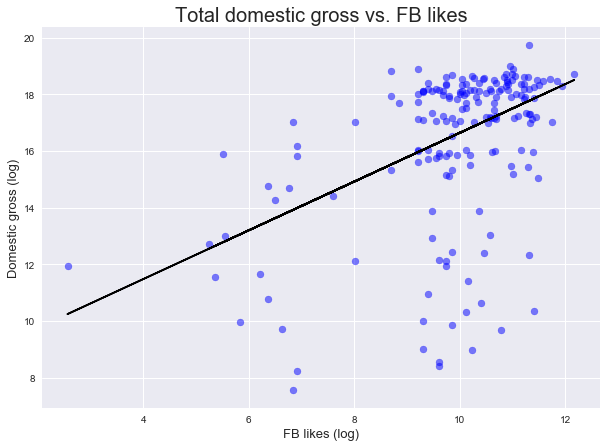

In [145]:
est=LinearRegression()

kf=KFold(n=len(X_train),n_folds=3, shuffle=True, random_state= 28)



for train,test in kf:
    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]
    
    predicted=np.array(y_cv_test.size*[0.0])
    
    est = LinearRegression()
    est.fit(X_cv_train.log_fb_likes.values.reshape(X_cv_train.log_fb_likes.size,1), y_cv_train) # building a model
    predicted = predicted + np.array(est.predict(X_cv_test.log_fb_likes.values.reshape(X_cv_test.log_fb_likes.size,1))) # getting the predictd values using test set from the test fold
    

fig, ax = plt.subplots(figsize=(10,7))
plt.scatter(X_cv_test.log_fb_likes, y_cv_test,color='b', alpha = 0.5)
plt.plot(X_cv_test.log_fb_likes, predicted,color='k')

ax.set_title('Total domestic gross vs. FB likes', fontsize = 20)
ax.set_xlabel('FB likes (log)', fontsize = 13)
ax.set_ylabel('Domestic gross (log)', fontsize = 13)


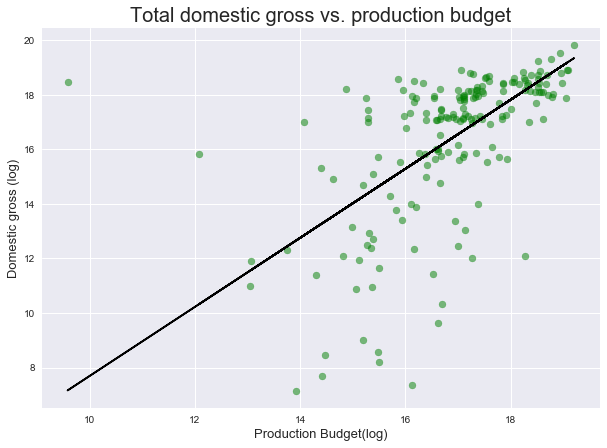

In [144]:
est=LinearRegression()

kf=KFold(n=len(X_train),n_folds=3, shuffle=True)



for train,test in kf:
    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]
    
    predicted2=np.array(y_cv_test.size*[0.0])
    
    est = LinearRegression()
    est.fit(X_cv_train.log_production_budget.values.reshape(X_cv_train.log_production_budget.size,1), y_cv_train) #building a model
    predicted2 = predicted2 + np.array(est.predict(X_cv_test.log_production_budget.values.reshape(X_cv_test.log_production_budget.size,1))) # getting the predictd values using test set from the test fold
    

fig2, ax2 = plt.subplots(figsize=(10,7))
plt.scatter(X_cv_test.log_production_budget, y_cv_test,color='g', alpha = 0.5)
plt.plot(X_cv_test.log_production_budget, predicted2, color='k')

ax2.set_title('Total domestic gross vs. production budget', fontsize = 20)
ax2.set_xlabel('Production Budget(log)', fontsize = 13)
ax2.set_ylabel('Domestic gross (log)', fontsize = 13)

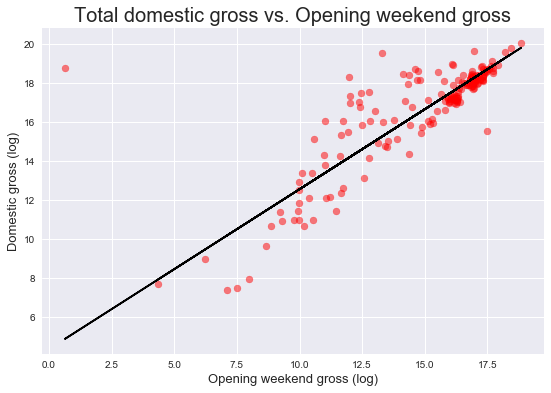

In [142]:
est=LinearRegression()

kf=KFold(n=len(X_train),n_folds=3, shuffle=True)



for train,test in kf:
    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]
    
    predicted3=np.array(y_cv_test.size*[0.0])
    
    est = LinearRegression()
    est.fit(X_cv_train.log_opening_weekend.values.reshape(X_cv_train.log_opening_weekend.size,1), y_cv_train) # building a model
    predicted3 = predicted3 + np.array(est.predict(X_cv_test.log_opening_weekend.values.reshape(X_cv_test.log_opening_weekend.size,1))) # getting the predictd values using test set from the test fold
    

fig3, ax3 = plt.subplots(figsize=(9,6))
plt.scatter(X_cv_test.log_opening_weekend, y_cv_test,color='r', alpha = 0.5)
plt.plot(X_cv_test.log_opening_weekend, predicted3, color='k')

ax3.set_title('Total domestic gross vs. Opening weekend gross', fontsize = 20)
ax3.set_xlabel('Opening weekend gross (log)', fontsize = 13)
ax3.set_ylabel('Domestic gross (log)', fontsize = 13)

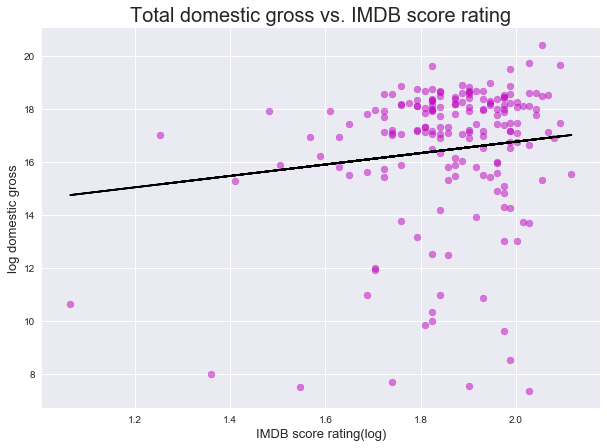

In [143]:
est=LinearRegression()

kf=KFold(n=len(X_train),n_folds=3, shuffle=True, random_state=13)



for train,test in kf:
    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]
    
    predicted4=np.array(y_cv_test.size*[0.0])
    
    est = LinearRegression()
    est.fit(X_cv_train.log_rating.values.reshape(X_cv_train.log_rating.size,1), y_cv_train) # building a model
    predicted4 = predicted4 + np.array(est.predict(X_cv_test.log_rating.values.reshape(X_cv_test.log_rating.size,1))) # getting the predictd values using test set from the test fold
    

fig4, ax4 = plt.subplots(figsize=(10,7))
plt.scatter(X_cv_test.log_rating, y_cv_test,color='m', alpha = 0.5)
plt.plot(X_cv_test.log_rating, predicted4,color='k')

ax4.set_title('Total domestic gross vs. IMDB score rating', fontsize = 20)
ax4.set_xlabel('IMDB score rating(log)', fontsize = 13)
ax4.set_ylabel('log domestic gross', fontsize = 13)

### Feature selecting through p-values

In [76]:

# Let's start with filtering features using p-value: 

est=LinearRegression()
from sklearn import feature_selection as f_select

sig_columns=[]
pvals=[]

for feature in X_train.columns:
    #get pval on feature by feature basis
    pval=f_select.f_regression(X_train[[feature]],y_train)
    sig_columns.append(feature)
    pvals.append(pval[1][0])

list(zip(sig_columns,pvals))


[('log_production_budget', 2.1043838028731034e-62),
 ('log_opening_weekend', 4.9833827404801929e-159),
 ('log_fb_likes', 4.8467256295240427e-37),
 ('log_rating', 4.1716210730708882e-05),
 ('inter_logfFBLikes_logOpening', 1.7230102326312576e-139)]

### Choosing the appropriate alpha for regularization

In [82]:
kf = KFold(n=len(X_train), n_folds=5, shuffle=True)
alphas=[1e-5,1e-4,1e-3,1e-2,1e-1]
all_mse_scores= np.array(len(alphas)*[0.0])


for train,test in kf:

    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]
    
    mse_score=[]
    for a in alphas:
        est=Lasso(alpha=a,fit_intercept=False)
        est.fit(X_cv_train,y_cv_train)
        mse = np.mean((np.array((y_cv_test))-est.predict(X_cv_test))**2)
        mse_score.append(mse)
    all_mse_scores += mse_score

print(all_mse_scores/len(alphas))
# it looks like 1e-4 gives lower MSE so lets use it

[ 12.64546807  12.64579486  12.6490781   12.68363729  13.01613244]


### Feature selecting with Lasso and checking estimates with Ridge and ElasticNet

In [84]:
from sklearn.linear_model import RidgeCV,LassoCV, ElasticNetCV

In [85]:
alphas = [1e-4]

In [86]:
# fitting and filtering with lasso
lcv = LassoCV(cv=5, alphas = alphas, fit_intercept = False, normalize=True)
lcv.fit(X_train, y_train)
lcv.score(X_train, y_train)

0.77141877545080129

In [87]:
# fitting and checking coef with ridge

rcv = RidgeCV(cv=5, alphas = alphas, fit_intercept = False, normalize=True)
rcv.fit(X_train, y_train)
rcv.score(X_train, y_train)


0.77152125186152309

In [88]:
# fitting and checking coef with ElasticNet

encv = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
                    cv=5, alphas = alphas, fit_intercept = False, normalize=True)
encv.fit(X_train, y_train)
encv.score(X_train, y_train)

0.77141863758990314

In [89]:
# estimated coef
print([feature for feature in X.columns])
print('Lasso:       ' + str(lcv.coef_))
print('Ridge:      ' + str(rcv.coef_))
print('Elastic_Net: ' + str(encv.coef_))

['log_production_budget', 'log_opening_weekend', 'log_fb_likes', 'log_rating', 'inter_logfFBLikes_logOpening']
Lasso:       [ 0.11465532  0.65613868  0.13416511  1.42930834  0.00555635]
Ridge:      [[ 0.13520351  0.62132316  0.08923534  1.49857492  0.00879053]]
Elastic_Net: [ 0.11479463  0.65614907  0.13430909  1.42765691  0.00555039]


### Cross val test predicted value with all the chosen regressors

In [90]:

kf=KFold(n=len(X_train),n_folds=5, shuffle=True)

all_scores=[]

for train,test in kf:
    X_cv_train= X_train.iloc[train]
    y_cv_train= y_train.iloc[train]
    X_cv_test= X_train.iloc[test]
    y_cv_test= y_train.iloc[test]

    est = LinearRegression()
    est.fit(X_cv_train, y_cv_train) # building a model
    predicted = est.predict(X_cv_test)
    residuals = est.predict(X_cv_test) - y_cv_test # getting the predictd values using test set from the test fold
    all_scores.append(est.score(X_cv_test, y_cv_test))

print(np.mean(all_scores))


0.751646635021


In [91]:
# a more blackbox way 
np.mean(cross_val_score(est, X_train, y_train,cv = 5,))


0.76510949637895254

## Testing my model through all the different optimization methods

In [92]:
print('OLS: ' + str(est.score(X_test,y_test)))
print('Ridge: ' + str(rcv.score(X_test,y_test)))
print('Lasso: ' + str(lcv.score(X_test,y_test)))
print('Elastic_Net: ' + str(encv.score(X_test,y_test)))


OLS: 0.763283439161
Ridge: 0.755452076002
Lasso: 0.756291564554
Elastic_Net: 0.756281158634


In [93]:
# Because my dataset is a bit small, 
# I ran the train test train split 'num' times and took the average of the R-squared values

num = 30

ols_R2 = np.array([0.0])
ridge_R2 = np.array([0.0])
lasso_R2 = np.array([0.0])
elastic_net_R2 = np.array([0.0])

for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    est = LinearRegression()
    est.fit(X_cv_train, y_cv_train)
    ols_R2 += est.score(X_test,y_test)

    lcv = LassoCV(cv=5, alphas = alphas, fit_intercept = False, normalize=True)
    lcv.fit(X_train, y_train)
    lasso_R2 += lcv.score(X_test,y_test)
    
    rcv = RidgeCV(cv=5, alphas = alphas, fit_intercept = False, normalize=True)
    rcv.fit(X_train, y_train)
    ridge_R2 += rcv.score(X_test,y_test)
    
    encv = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],
                        cv=5, alphas = alphas, fit_intercept = False, normalize=True)
    encv.fit(X_train, y_train)
    elastic_net_R2 += encv.score(X_test,y_test)

print('OLS: ' + str(ols_R2/num))
print('Ridge: ' + str(ridge_R2/num))
print('Lasso: ' + str(lasso_R2/num))
print('Elastic_Net: ' + str(elastic_net_R2/num))



OLS: [ 0.76913625]
Ridge: [ 0.75210374]
Lasso: [ 0.75232036]
Elastic_Net: [ 0.75232436]
